Loading in the file and computing Fourier Transform

In [1]:
from scipy.io import wavfile
import numpy as np
import librosa
import matplotlib.pyplot as plt
%matplotlib inline

/home/skank/envs/sci/local/lib/python2.7/site-packages/librosa/core/audio.py:37: UserWarning: Could not import scikits.samplerate. Falling back to scipy.signal
  warnings.warn('Could not import scikits.samplerate. '


In [2]:
pcm, sr = librosa.load('sound/vs1-4prs.wav', sr=44100)

(1025, 17006)

/home/skank/envs/sci/local/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


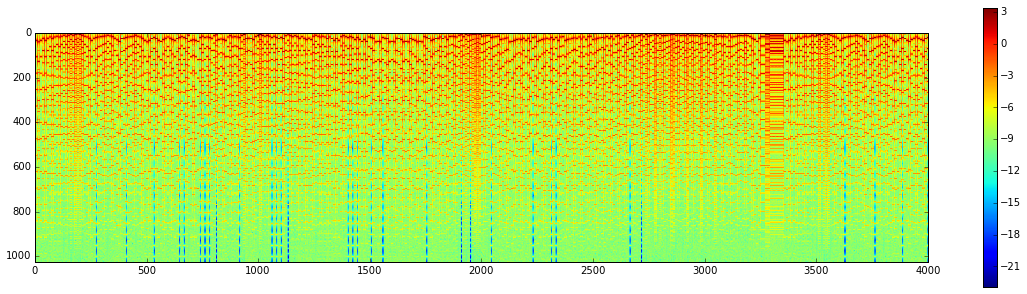

In [3]:
S = np.abs(librosa.core.stft(pcm))
plt.figure(figsize=(20,5))
plt.imshow(np.log(S)[:,:4000])
plt.colorbar()
S.shape

I'll use scikit-learn's implementation of NMF

In [4]:
from sklearn.decomposition import NMF
model = NMF(n_components=5,init='random', random_state=0)
W = model.fit_transform(S);
H = model.components_;
#rows of H are when the notes are hit, and the columns of W are what frequency the beats are
H.shape, W.shape, S.shape

((5, 17006), (1025, 5), (1025, 17006))

The columns of W should be in the frequency domain.  I'd like to see what the components look like, and then what they sound like.

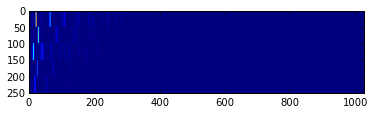

In [5]:
plt.imshow(W.repeat(50, axis=1).transpose())

In [6]:
for i in range(W.shape[1]):
    sound = librosa.core.istft(W[:,i][:,np.newaxis].repeat(50, axis=1))
    librosa.output.write_wav('output/component_{}'.format(i), sound, sr=44100, norm=False)

Out of curiosity, let's check the reconstruction error.

0.3640513889701919

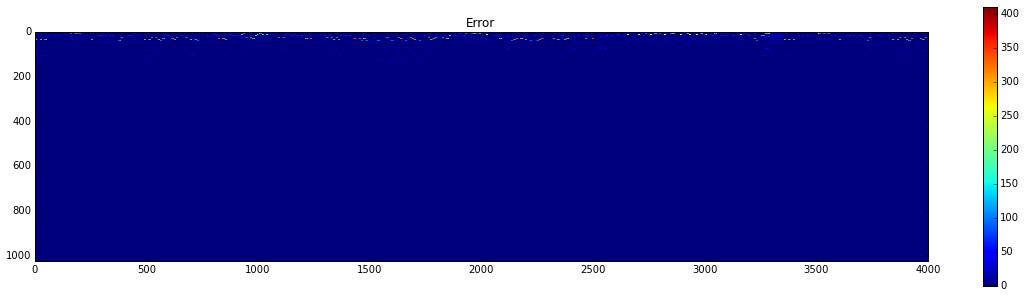

In [7]:
plt.figure(figsize=(20, 5))
plt.imshow(((S-W.dot(H))**2)[:,:4000])
plt.colorbar()
plt.title("Error")
np.sum((S-W.dot(H))**2)/(S.shape[0]*S.shape[1])

Hmm, looks pretty good from here... But what would it sound like if we listened to the reconstructed song?

In [69]:
sound = librosa.core.istft(W.dot(H))
librosa.output.write_wav('output/reconstruction_{}_components'.format(5), sound, sr=44100, norm=False)

Not very convincing.  I guess Bach uses more than 5 notes in his songs.  Who knew?

I'll try again with 100.

0.72717479047683908

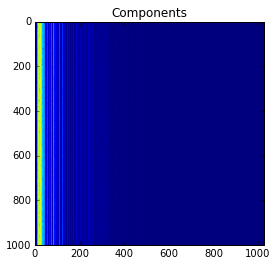

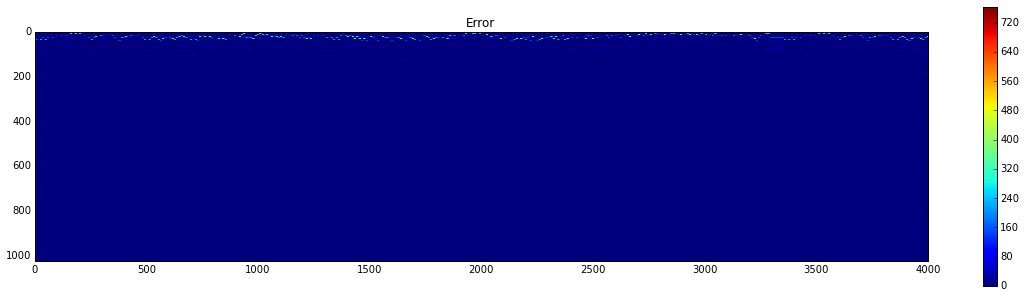

In [70]:
model = NMF(n_components=100,init='random', random_state=0)
W = model.fit_transform(S);
H = model.components_;
plt.imshow(W.repeat(10, axis=1).transpose())
plt.title("Components")
for i in range(W.shape[1]):
    sound = librosa.core.istft(W[:,i][:,np.newaxis].repeat(50, axis=1), norm=False)
    librosa.output.write_wav('output/component_{}'.format(i), sound, sr=44100)
plt.figure(figsize=(20, 5))
plt.imshow(((S-W.dot(H))**2)[:,:4000])
plt.colorbar()
plt.title("Error")
sound = librosa.core.istft(W.dot(H))
librosa.output.write_wav('output/reconstruction_{}_components'.format(100), sound, sr=44100, norm=False)
np.sum((S-W.dot(H))**2)/(S.shape[0]*S.shape[1])

The error went up, and the output sounds much worse than the 5-component output was!  Maybe because I didn't regularize.  But still, it's so bad... seems like something's wrong.  I'll try a number between 5 and 100.  How about 20?

0.5781250693668144

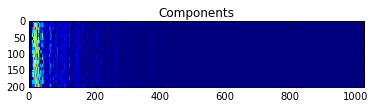

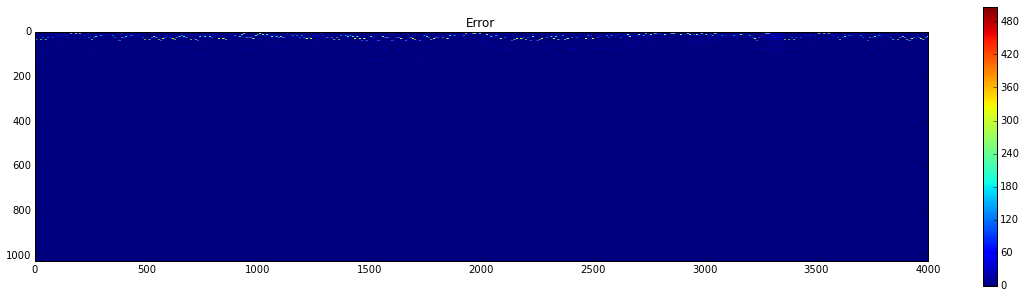

In [72]:
model = NMF(n_components=20,init='random', random_state=0)
W = model.fit_transform(S);
H = model.components_;
plt.imshow(W.repeat(10, axis=1).transpose())
plt.title("Components")
for i in range(W.shape[1]):
    sound = librosa.core.istft(W[:,i][:,np.newaxis].repeat(50, axis=1))
    librosa.output.write_wav('output/component_{}'.format(i), sound, sr=44100)
plt.figure(figsize=(20, 5))
plt.imshow(((S-W.dot(H))**2)[:,:4000])
plt.colorbar()
plt.title("Error")
sound = librosa.core.istft(W.dot(H))
librosa.output.write_wav('output/reconstruction_{}_components'.format(20), sound, sr=44100, norm=False)
np.sum((S-W.dot(H))**2)/(S.shape[0]*S.shape[1])

Enough experimenting.  Let's do some grad student descent on the regularization parameter and number of components.  I'll plot the reconstruction error and output a reconstructed sound file for each value.

In [9]:
import os
from sklearn.decomposition import NMF
error = []
for alpha in np.logspace(-1,1, num=10):
    if not os.path.exists("output/alpha_{:.2f}".format(alpha)):
        os.mkdir("output/alpha_{:.2f}".format(alpha))
    for n_components in [2,5,20]:
        model = NMF(n_components=n_components, init='nndsvd', random_state=0, alpha=alpha)
        W = model.fit_transform(S);
        H = model.components_;
        sound = librosa.core.istft(W.dot(H))
        librosa.output.write_wav('output/alpha_{:.2f}/reconstruction_{}_components'.format(alpha, n_components), sound, sr=44100)
        error.append((alpha, n_components, model.reconstruction_err_))
        print model.reconstruction_err_

3252.25712215
2519.09395946
643.090269826
3252.25712674
2519.09397815
643.090948817
3252.2571396
2519.09403737
643.092614762
3252.25717605
2519.0941956
643.096903451
3252.25728045
2519.09461528
643.107759256
3252.2575832
2519.09573099
643.134317114
3252.25846763
2519.0987388
643.205980161
3252.26102474
2519.10698162
643.402267341
3252.26821776
2519.12978743
643.935865541
3252.28811003
2519.19343821
645.368816536


Plot the reconstruction error against alpha values and component values

30


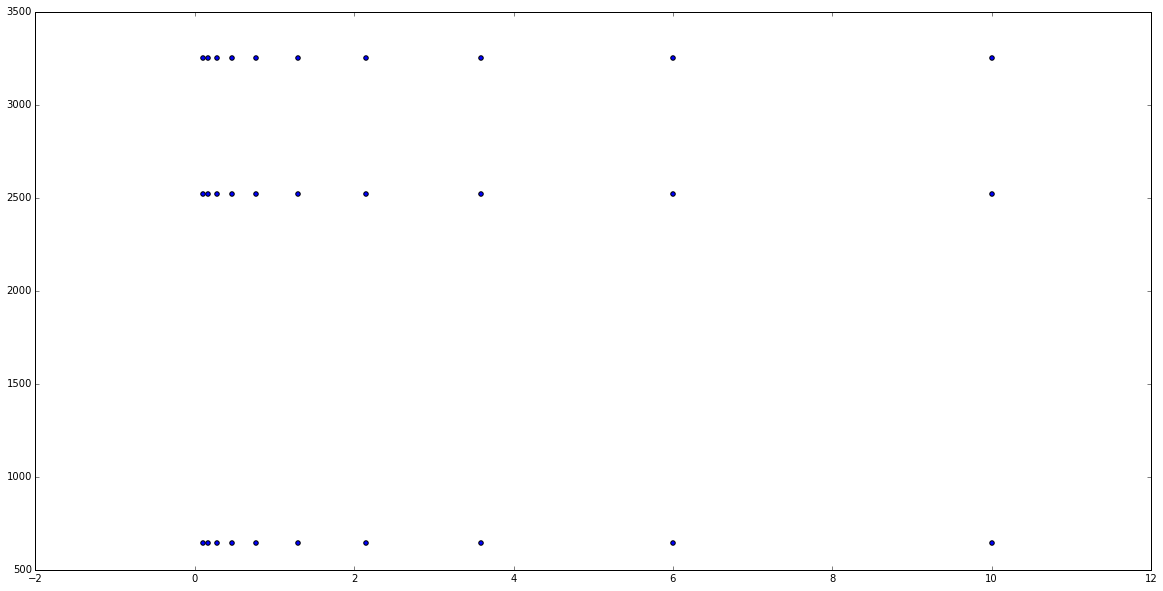

30


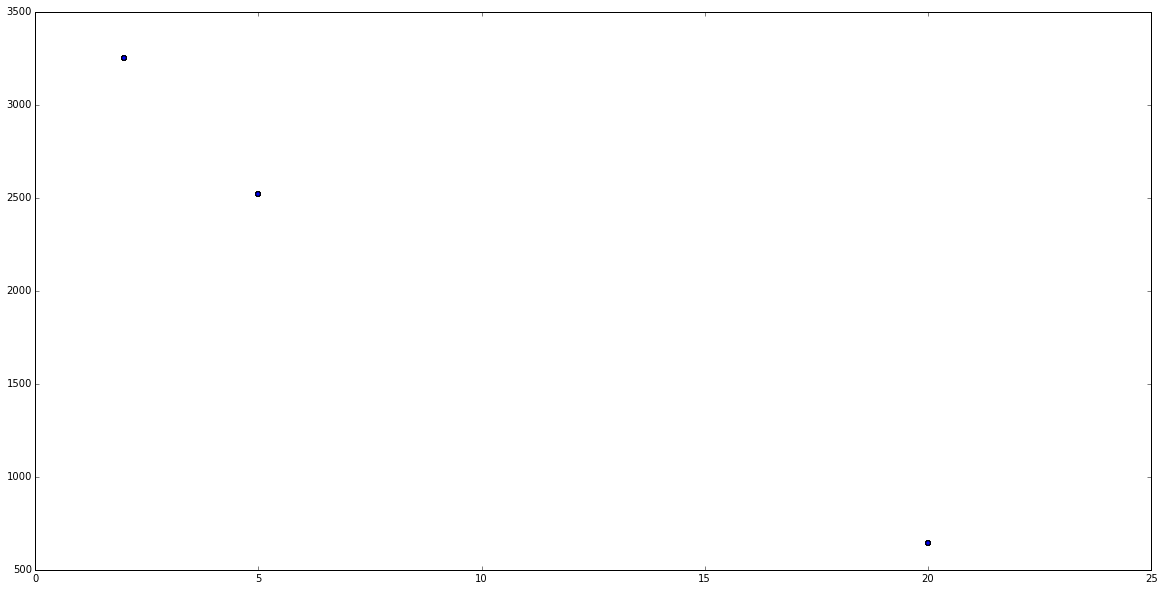

[(0.10000000000000001, 2, 3252.2571221507415), (0.10000000000000001, 5, 2519.0939594637985), (0.10000000000000001, 20, 643.090269826471), (0.16681005372000587, 2, 3252.257126740923), (0.16681005372000587, 5, 2519.09397815066), (0.16681005372000587, 20, 643.0909488174028), (0.27825594022071243, 2, 3252.2571396008775), (0.27825594022071243, 5, 2519.094037370722), (0.27825594022071243, 20, 643.0926147620444), (0.46415888336127786, 2, 3252.25717605199), (0.46415888336127786, 5, 2519.094195601667), (0.46415888336127786, 20, 643.0969034513816), (0.774263682681127, 2, 3252.2572804513175), (0.774263682681127, 5, 2519.09461528402), (0.774263682681127, 20, 643.1077592563124), (1.2915496650148841, 2, 3252.2575831960107), (1.2915496650148841, 5, 2519.095730992764), (1.2915496650148841, 20, 643.1343171135168), (2.1544346900318834, 2, 3252.258467627342), (2.1544346900318834, 5, 2519.0987387996734), (2.1544346900318834, 20, 643.2059801607222), (3.5938136638046259, 2, 3252.261024737151), (3.5938136638

In [10]:
print len(error)
plt.figure(figsize=(20, 10))
for alpha, components, err in error:
    plt.scatter(alpha, err)
plt.show()
print len(error)
plt.figure(figsize=(20, 10))
for alpha, components, err in error:
    plt.scatter(components, err)
plt.show()
print error